# CIFAR-10 Linear Model

La première étape intermédiaire de notre projet est d'utiliser les algorithmes ci-dessous sur le célébre dataset CIFAR-10.

Les algorithmes à étudier :

**Modèles précédents**
- Modèle Linéaire
- Perceptron Multicouches

**Nouveaux modèles**
- ConvNet(s)
- ResNets / HighwayNets 
- RNN(s)

Pour chacun des algorithmes cités, il faut :
1. L'influence de tous les hyperparamètres des modèles
    - Structure
    - Fonctions d'activations
    - etc.
2. Les paramètres des algorithmes d'apprentissages
    - Learning Rate
    - Momentum
    - etc.
    
----

### Méthodologie
1. Créer un modèle classique.
2. Entraîner le modèle pendant 500 epochs.
3. Examiner sa courbe TensorBoard et son accuracy.
4. Augmenter un des hyperparamètre.
5. Réduire ce même hyperparamètre.
6. Dire l'influence de cette hyperparamètre sur la courbe et sur le modèle de manière générale.
7. Recommencer à partir de l'étape 3 pour tout les hyperparamètres possibles.

#### Hyperparamètres
- Batch size
- Learning rate
- Momentum
- Structure
- Fonction d'activation
- Initialization de kernel
- Regularizers (Dropout, L1 Norm, L2 Norm)

#### Qui s'occupe de quoi ?
- Perceptron (Mamadian)
- MLP (Réda M.)
- ConvNet (Reda B.)

In [2]:
import os
import numpy as np
from numpy.random import seed
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Conv2D, BatchNormalization, Input, Average, MaxPool2D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.activations import relu, softmax, tanh
from tensorflow.keras.initializers import he_normal, glorot_uniform
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.regularizers import l2, l1, l1_l2
from tensorflow.random import set_seed

In [2]:
print("Version de TensorFlow :", tf.__version__)
print("Nom du GPU :", tf.test.gpu_device_name())

tf.keras.backend.clear_session()
tf.config.optimizer.set_jit(False)

Version de TensorFlow : 2.7.0
Nom du GPU : /device:GPU:0
Metal device set to: Apple M1


2021-12-27 23:41:43.057863: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-27 23:41:43.057951: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Importation du dataset

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [4]:
NUM_CLASSES = 10
IMG_SIZE = x_train[0].shape

In [5]:
x_train = x_train.astype('float32') / 256
x_test = x_test.astype('float32') / 256

y_train = to_categorical(y_train, num_classes=NUM_CLASSES)
y_test = to_categorical(y_test, num_classes=NUM_CLASSES)

In [6]:
LOG_DIR = os.path.join("logs")

## Fixer les seeds

In [7]:
set_seed(42) # TensorFlow
seed(42) # NumPy

# Modèle linéaire

In [8]:
EPOCHS = 500
SHUFFLE = True
BATCH_SIZE = 256

In [9]:
class Perceptron(Model):
    def __init__(self, activation_function, kernel_initializer, l2_val=0, l1_val=0):
        super(Perceptron, self).__init__()
        self._flatten_layer = Flatten()
        if l1_val > 0 and l2_val > 0:
            self._dense_layer = Dense(IMG_SIZE[0] * IMG_SIZE[1] * IMG_SIZE[2],
                                      activation=activation_function,
                                      kernel_initializer=kernel_initializer,
                                      kernel_regularizer=l1_l2(l1_val, l2_val),
                                      bias_regularizer=l1_l2(l1_val, l2_val)
                                      )
        elif l1_val > 0:
            self._dense_layer = Dense(IMG_SIZE[0] * IMG_SIZE[1] * IMG_SIZE[2],
                                      activation=activation_function,
                                      kernel_initializer=kernel_initializer,
                                      kernel_regularizer=l1(l1_val),
                                      bias_regularizer=l1(l1_val)
                                      )
        elif l2_val > 0:
            self._dense_layer = Dense(IMG_SIZE[0] * IMG_SIZE[1] * IMG_SIZE[2],
                                      activation=activation_function,
                                      kernel_initializer=kernel_initializer,
                                      kernel_regularizer=l2(l2_val),
                                      bias_regularizer=l2(l2_val)
                                      )
        else:
            self._dense_layer = Dense(IMG_SIZE[0] * IMG_SIZE[1] * IMG_SIZE[2],
                                      activation=activation_function,
                                      kernel_initializer=kernel_initializer
                                      )
        self._output_layer = Dense(NUM_CLASSES, activation=softmax)
                
    
    def call(self, inputs):
        x = self._flatten_layer(inputs)
        x = self._dense_layer(x)
        return self._output_layer(x)

### Main Linear Model

Hyperparameters

In [ ]:
learning_rate = 0.01
momentum = 0.0
l2_val = 0.00
l1_val = 0.00
using_l1 = l1_val > 0
using_l2 = l2_val > 0
ki = glorot_uniform
fa = tanh
version = '_pft'

training

In [ ]:
perceptron = Perceptron(fa, ki, l1_val=l1_val, l2_val=l2_val)
perceptron.compile(loss=categorical_crossentropy,
                   optimizer=SGD(learning_rate=learning_rate,
                                 momentum=momentum),
                   metrics=categorical_accuracy)

log_name = os.path.join(LOG_DIR,
                            "linear",
                            f"linear_model_ep_{EPOCHS}_bs_{BATCH_SIZE}_opt_SGD_lr_{learning_rate}_mo_{momentum}_{('l1_'+str(l1_val)+'_l2_'+str(l2_val) if using_l1 and using_l2 else ('l1_'+str(l1_val) if using_l1 else ('l2_'+str(l2_val) if using_l2 else '')))}_ki_{ki.__name__}_af_{fa.__name__}{version}")

print(log_name)
perceptron.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_test, y_test), shuffle=True, callbacks=[TensorBoard(log_name, histogram_freq=1)])

### learning rate analysis Models

hyperparameters

In [12]:
learning_rate = [0.05,0.2,0.001]
momentum = 0.0
l2_val = 0.00
l1_val = 0.00
using_l1 = l1_val > 0
using_l2 = l2_val > 0
ki = glorot_uniform
fa = tanh
version = '_pft'

training

In [ ]:
for lr in learning_rate:
    perceptron = Perceptron(fa, ki, l1_val=l1_val, l2_val=l2_val)
    perceptron.compile(loss=categorical_crossentropy,
                   optimizer=SGD(learning_rate=lr,
                                 momentum=momentum),
                   metrics=categorical_accuracy)

    log_name = os.path.join(LOG_DIR,
                            "linear",
                            f"linear_model_ep_{EPOCHS}_bs_{BATCH_SIZE}_opt_SGD_lr_{lr}_mo_{momentum}_{('l1_'+str(l1_val)+'_l2_'+str(l2_val) if using_l1 and using_l2 else ('l1_'+str(l1_val) if using_l1 else ('l2_'+str(l2_val) if using_l2 else '')))}_ki_{ki.__name__}_af_{fa.__name__}{version}")

    print(log_name)
    perceptron.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_test, y_test), shuffle=True, callbacks=[TensorBoard(log_name, histogram_freq=1)])

2021-12-27 23:42:23.175366: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-27 23:42:23.175408: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


logs/linear/linear_model_ep_500_bs_256_opt_SGD_lr_0.05_mo_0.0__ki_GlorotUniform_af_tanh_pft


2021-12-27 23:42:23.587556: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-12-27 23:42:23.719394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/500
193/196 [============================>.] - ETA: 0s - loss: 3.4226 - categorical_accuracy: 0.2859

2021-12-27 23:42:26.985005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


196/196 [==============================] - 4s 20ms/step - loss: 3.4045 - categorical_accuracy: 0.2868 - val_loss: 1.8901 - val_categorical_accuracy: 0.3129
Epoch 2/500
196/196 [==============================] - 3s 17ms/step - loss: 1.8312 - categorical_accuracy: 0.3578 - val_loss: 1.8303 - val_categorical_accuracy: 0.3496
Epoch 3/500
196/196 [==============================] - 4s 18ms/step - loss: 1.8035 - categorical_accuracy: 0.3707 - val_loss: 1.8133 - val_categorical_accuracy: 0.3618
Epoch 4/500
196/196 [==============================] - 4s 18ms/step - loss: 1.7822 - categorical_accuracy: 0.3787 - val_loss: 1.8517 - val_categorical_accuracy: 0.3350
Epoch 5/500
196/196 [==============================] - 4s 18ms/step - loss: 1.7586 - categorical_accuracy: 0.3866 - val_loss: 1.7654 - val_categorical_accuracy: 0.3864
Epoch 6/500
196/196 [==============================] - 4s 18ms/step - loss: 1.7452 - categorical_accuracy: 0.3920 - val_loss: 1.7907 - val_categorical_accuracy: 0.3732
Epoc

2021-12-28 00:15:12.267345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


196/196 [==============================] - ETA: 0s - loss: 259.4275 - categorical_accuracy: 0.0990

2021-12-28 00:15:15.729786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


196/196 [==============================] - 4s 21ms/step - loss: 259.4275 - categorical_accuracy: 0.0990 - val_loss: 246.6462 - val_categorical_accuracy: 0.1000
Epoch 2/500
196/196 [==============================] - 4s 20ms/step - loss: 265.6273 - categorical_accuracy: 0.1013 - val_loss: 337.1910 - val_categorical_accuracy: 0.1000
Epoch 3/500
196/196 [==============================] - 4s 21ms/step - loss: 250.0977 - categorical_accuracy: 0.1054 - val_loss: 240.4312 - val_categorical_accuracy: 0.1000
Epoch 4/500
196/196 [==============================] - 4s 21ms/step - loss: 211.0315 - categorical_accuracy: 0.1190 - val_loss: 166.1388 - val_categorical_accuracy: 0.1497
Epoch 5/500
196/196 [==============================] - 4s 21ms/step - loss: 189.3229 - categorical_accuracy: 0.1275 - val_loss: 137.1945 - val_categorical_accuracy: 0.1657
Epoch 6/500
196/196 [==============================] - 4s 21ms/step - loss: 174.2457 - categorical_accuracy: 0.1325 - val_loss: 126.7258 - val_categoric

2021-12-28 00:48:22.169016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


193/196 [============================>.] - ETA: 0s - loss: 2.2111 - categorical_accuracy: 0.2000

2021-12-28 00:48:25.534490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


196/196 [==============================] - 5s 23ms/step - loss: 2.2102 - categorical_accuracy: 0.2006 - val_loss: 2.1217 - val_categorical_accuracy: 0.2605
Epoch 2/500
196/196 [==============================] - 4s 19ms/step - loss: 2.0742 - categorical_accuracy: 0.2759 - val_loss: 2.0340 - val_categorical_accuracy: 0.2932
Epoch 3/500
196/196 [==============================] - 4s 19ms/step - loss: 2.0079 - categorical_accuracy: 0.3022 - val_loss: 1.9853 - val_categorical_accuracy: 0.3174
Epoch 4/500
196/196 [==============================] - 4s 21ms/step - loss: 1.9662 - categorical_accuracy: 0.3194 - val_loss: 1.9491 - val_categorical_accuracy: 0.3298
Epoch 5/500
196/196 [==============================] - 4s 20ms/step - loss: 1.9362 - categorical_accuracy: 0.3320 - val_loss: 1.9231 - val_categorical_accuracy: 0.3396
Epoch 6/500
196/196 [==============================] - 4s 19ms/step - loss: 1.9133 - categorical_accuracy: 0.3411 - val_loss: 1.9035 - val_categorical_accuracy: 0.3468
Epoc

#### Resultat:


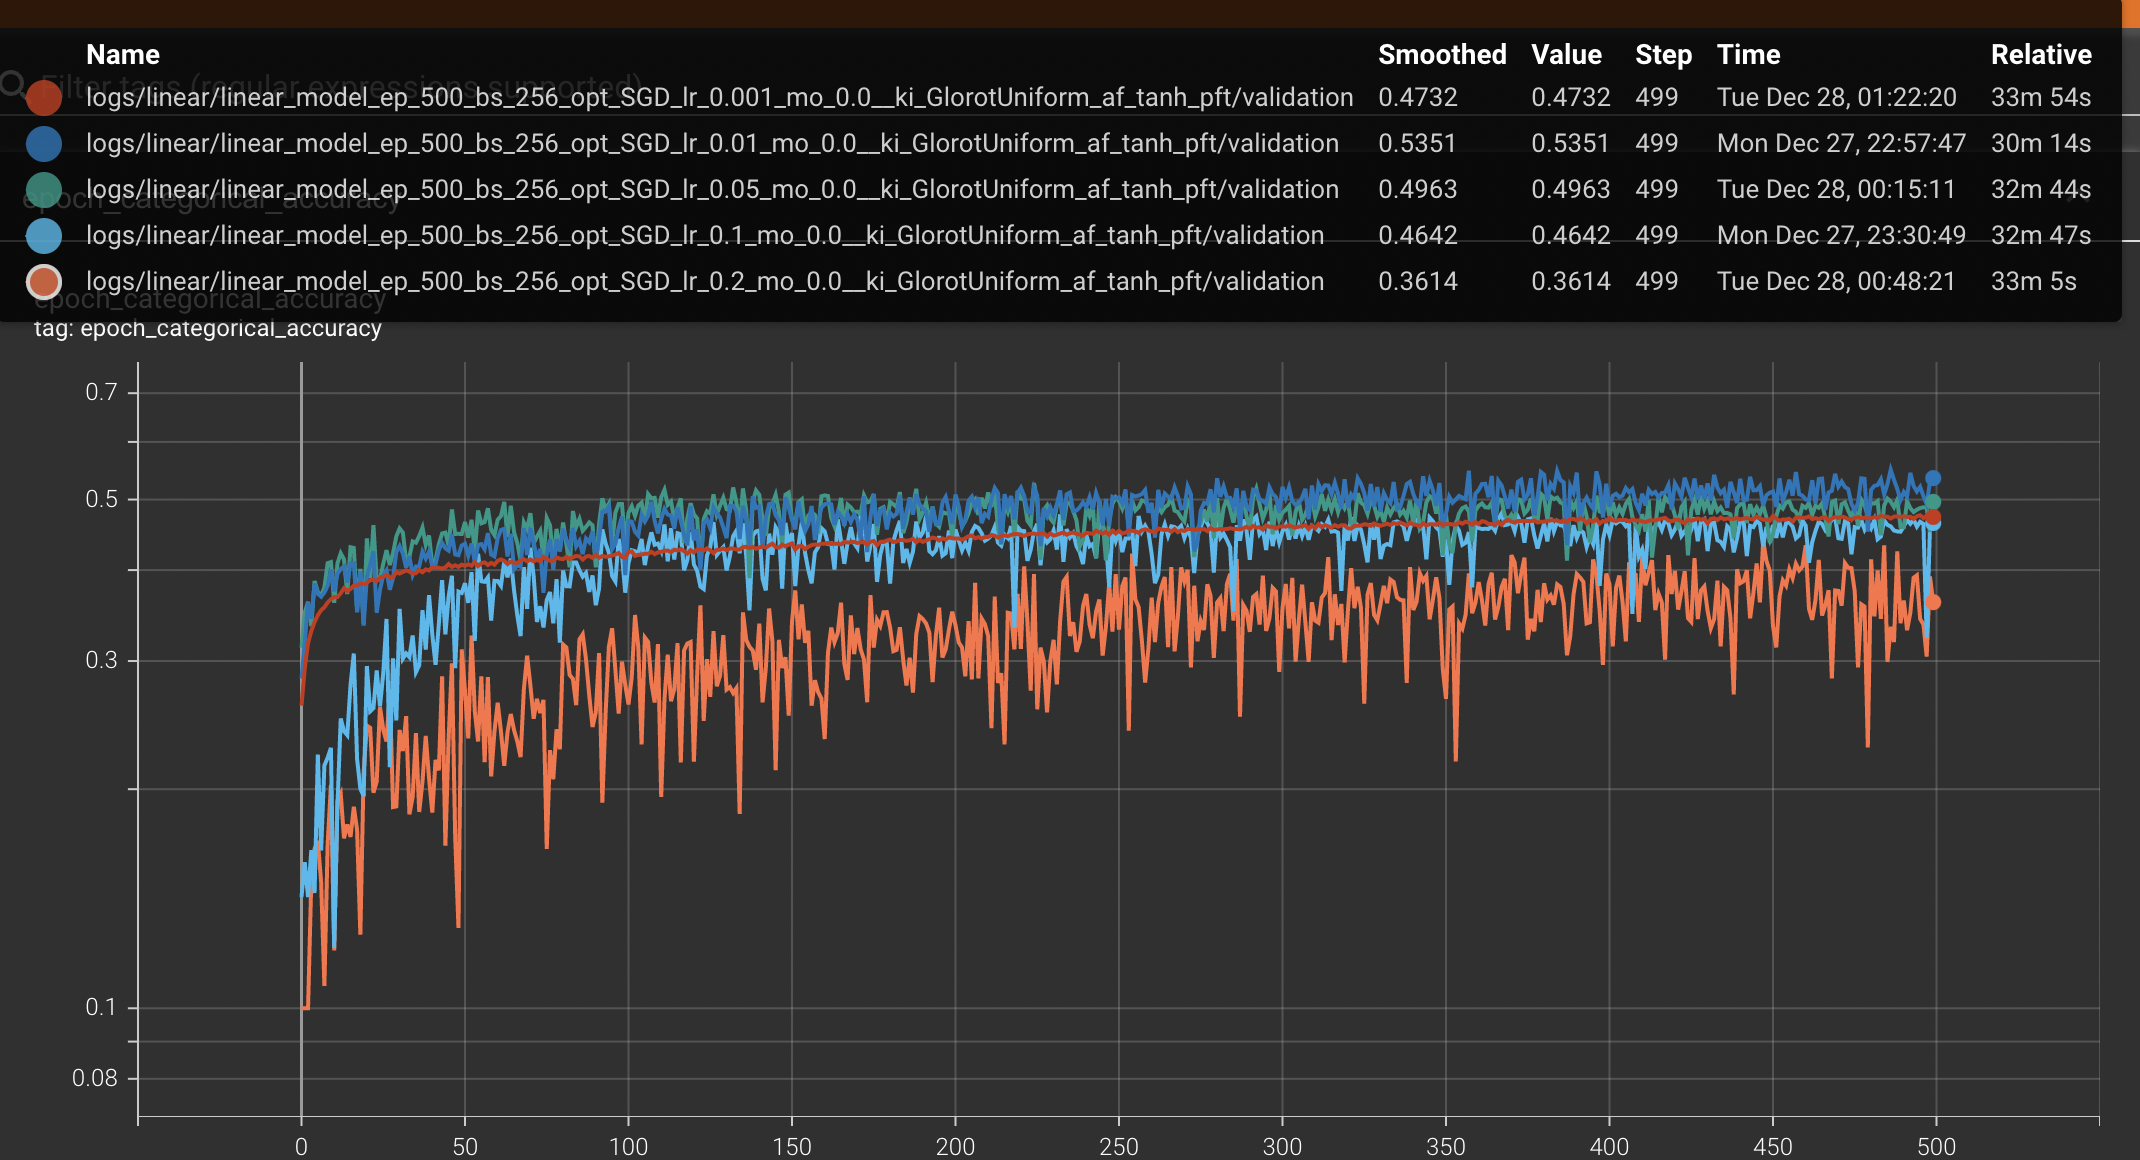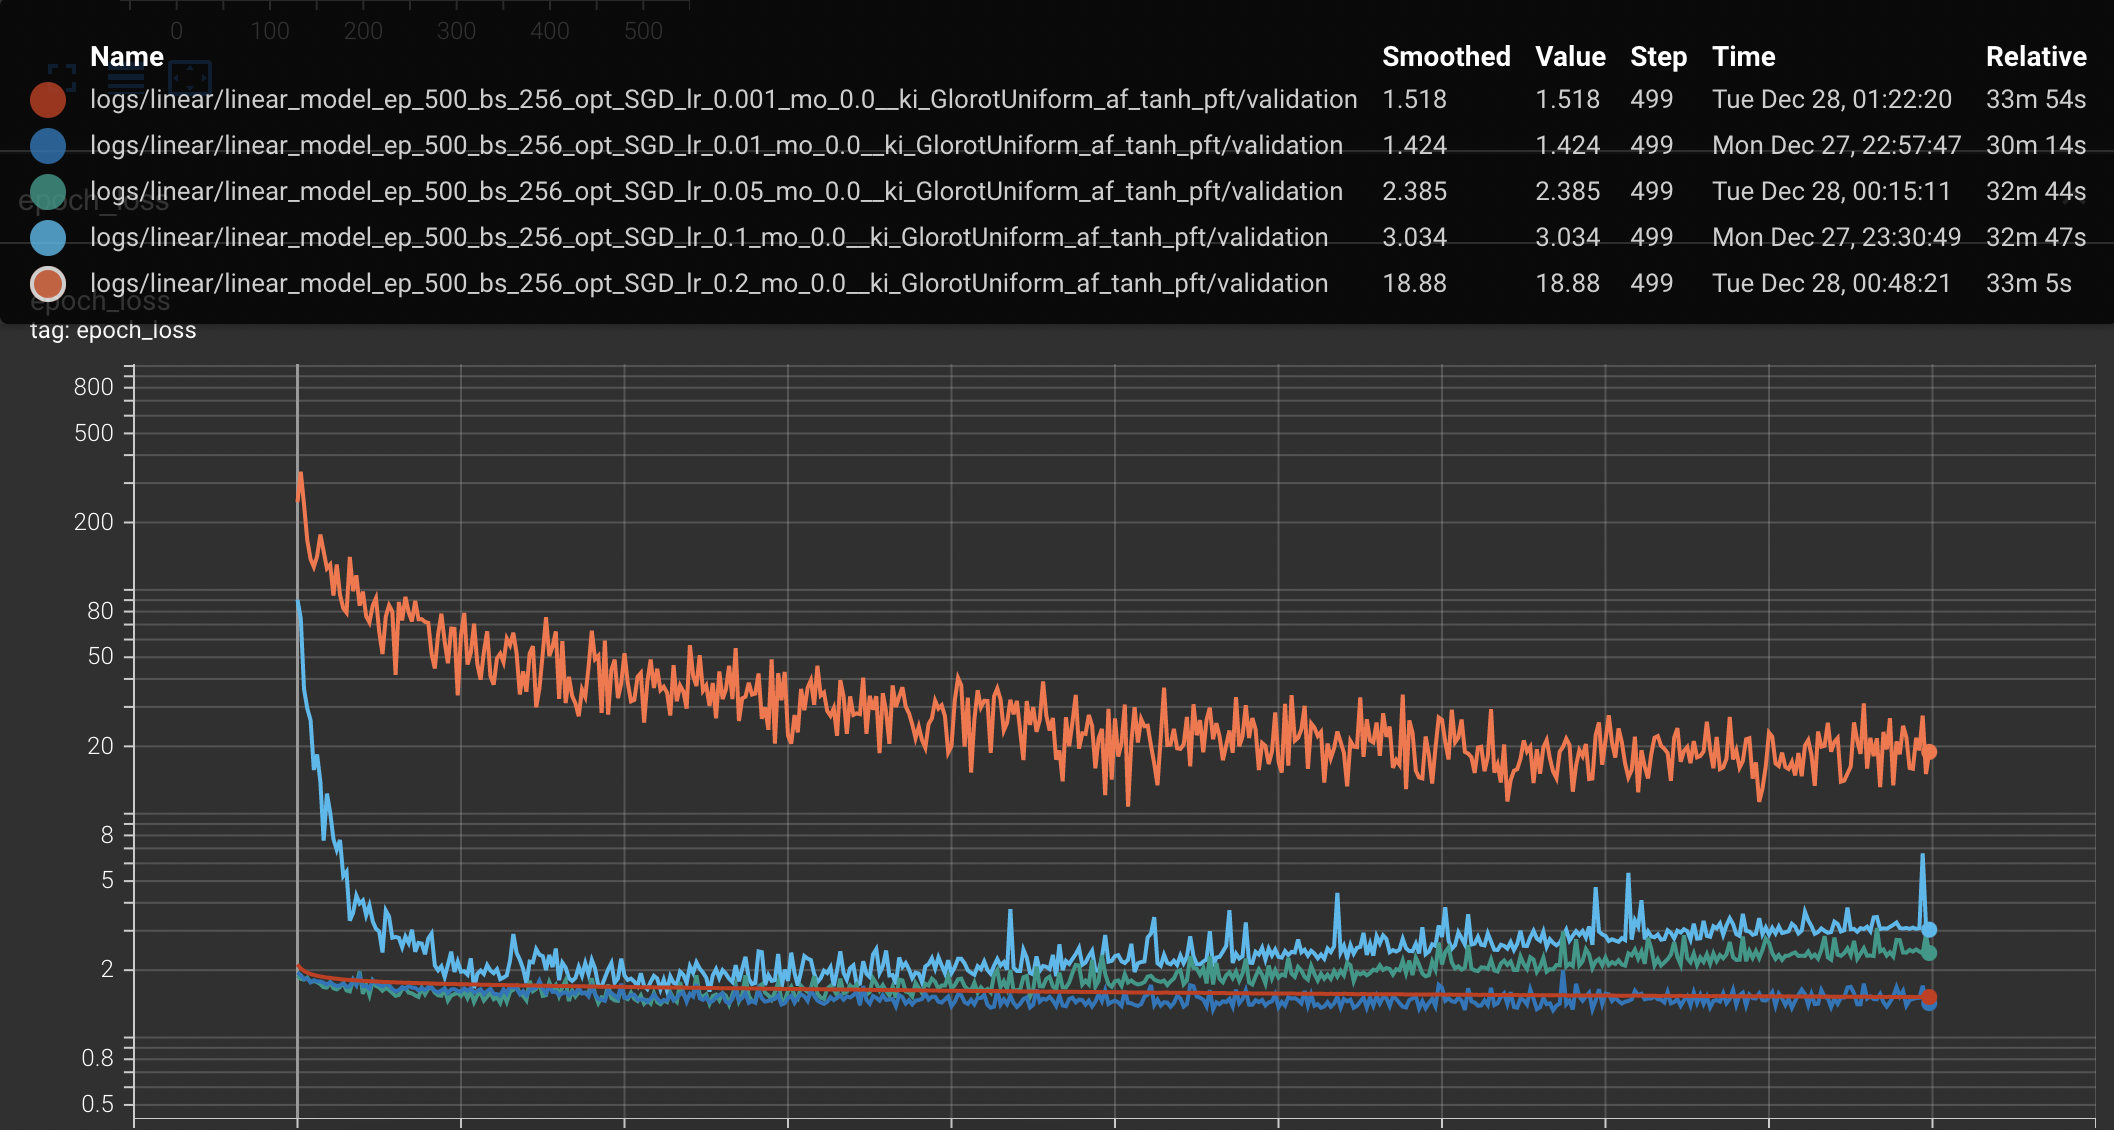


### Momentum analysis Models

In [14]:
learning_rate = 0.01
momentum = [0.1, 0.5, 0.9]
l2_val = 0.00
l1_val = 0.00
using_l1 = l1_val > 0
using_l2 = l2_val > 0
ki = glorot_uniform
fa = tanh
version = '_pft'

training

In [ ]:
for mt in momentum:
    perceptron = Perceptron(fa, ki, l1_val=l1_val, l2_val=l2_val)
    perceptron.compile(loss=categorical_crossentropy,
                   optimizer=SGD(learning_rate=learning_rate,
                                 momentum=mt),
                   metrics=categorical_accuracy)

    log_name = os.path.join(LOG_DIR,
                            "linear",
                            f"linear_model_ep_{EPOCHS}_bs_{BATCH_SIZE}_opt_SGD_lr_{learning_rate}_mo_{mt}_{('l1_'+str(l1_val)+'_l2_'+str(l2_val) if using_l1 and using_l2 else ('l1_'+str(l1_val) if using_l1 else ('l2_'+str(l2_val) if using_l2 else '')))}_ki_{ki.__name__}_af_{fa.__name__}{version}")

    print(log_name)
    perceptron.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_test, y_test), shuffle=True, callbacks=[TensorBoard(log_name, histogram_freq=1)])

logs/linear/linear_model_ep_500_bs_256_opt_SGD_lr_0.01_mo_0.1__ki_GlorotUniform_af_tanh_pft
Epoch 1/500
  8/196 [>.............................] - ETA: 3s - loss: 2.3344 - categorical_accuracy: 0.1367

2021-12-28 01:50:37.033112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


195/196 [============================>.] - ETA: 0s - loss: 1.9861 - categorical_accuracy: 0.2907

2021-12-28 01:50:40.256020: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


196/196 [==============================] - 4s 20ms/step - loss: 1.9860 - categorical_accuracy: 0.2908 - val_loss: 1.9577 - val_categorical_accuracy: 0.2814
Epoch 2/500
196/196 [==============================] - 3s 18ms/step - loss: 1.8483 - categorical_accuracy: 0.3499 - val_loss: 1.8874 - val_categorical_accuracy: 0.3241
Epoch 3/500
196/196 [==============================] - 3s 18ms/step - loss: 1.8002 - categorical_accuracy: 0.3702 - val_loss: 1.8234 - val_categorical_accuracy: 0.3608
Epoch 4/500
196/196 [==============================] - 3s 17ms/step - loss: 1.7801 - categorical_accuracy: 0.3784 - val_loss: 1.8434 - val_categorical_accuracy: 0.3362
Epoch 5/500
196/196 [==============================] - 4s 18ms/step - loss: 1.7599 - categorical_accuracy: 0.3867 - val_loss: 1.7669 - val_categorical_accuracy: 0.3801
Epoch 6/500
196/196 [==============================] - 4s 19ms/step - loss: 1.7445 - categorical_accuracy: 0.3936 - val_loss: 1.8046 - val_categorical_accuracy: 0.3735
Epoc

2021-12-28 02:23:12.255221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


194/196 [============================>.] - ETA: 0s - loss: 1.9418 - categorical_accuracy: 0.3081

2021-12-28 02:23:15.729116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


196/196 [==============================] - 5s 23ms/step - loss: 1.9415 - categorical_accuracy: 0.3082 - val_loss: 1.9117 - val_categorical_accuracy: 0.3018
Epoch 2/500
196/196 [==============================] - 4s 21ms/step - loss: 1.8111 - categorical_accuracy: 0.3668 - val_loss: 1.8109 - val_categorical_accuracy: 0.3609
Epoch 3/500
196/196 [==============================] - 4s 21ms/step - loss: 1.7661 - categorical_accuracy: 0.3836 - val_loss: 1.7693 - val_categorical_accuracy: 0.3780
Epoch 4/500
196/196 [==============================] - 4s 21ms/step - loss: 1.7490 - categorical_accuracy: 0.3887 - val_loss: 1.7563 - val_categorical_accuracy: 0.3849
Epoch 5/500
196/196 [==============================] - 4s 21ms/step - loss: 1.7231 - categorical_accuracy: 0.4007 - val_loss: 1.7572 - val_categorical_accuracy: 0.3777
Epoch 6/500
196/196 [==============================] - 4s 20ms/step - loss: 1.7070 - categorical_accuracy: 0.4051 - val_loss: 1.7685 - val_categorical_accuracy: 0.3907
Epoc

2021-12-28 02:57:59.963330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


195/196 [============================>.] - ETA: 0s - loss: 1.9420 - categorical_accuracy: 0.3212

2021-12-28 02:58:03.676455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


196/196 [==============================] - 5s 24ms/step - loss: 1.9419 - categorical_accuracy: 0.3211 - val_loss: 1.9142 - val_categorical_accuracy: 0.3308
Epoch 2/500
196/196 [==============================] - 4s 21ms/step - loss: 1.7903 - categorical_accuracy: 0.3720 - val_loss: 1.8125 - val_categorical_accuracy: 0.3653
Epoch 3/500
196/196 [==============================] - 4s 22ms/step - loss: 1.7024 - categorical_accuracy: 0.4010 - val_loss: 1.7210 - val_categorical_accuracy: 0.3968
Epoch 4/500
196/196 [==============================] - 4s 22ms/step - loss: 1.6581 - categorical_accuracy: 0.4172 - val_loss: 1.6831 - val_categorical_accuracy: 0.4096
Epoch 5/500
196/196 [==============================] - 4s 21ms/step - loss: 1.6242 - categorical_accuracy: 0.4300 - val_loss: 1.6244 - val_categorical_accuracy: 0.4260
Epoch 6/500
196/196 [==============================] - 4s 21ms/step - loss: 1.5918 - categorical_accuracy: 0.4424 - val_loss: 1.5854 - val_categorical_accuracy: 0.4409
Epoc

### Kernel Initializer analysis Models

hyperparameters

In [16]:
learning_rate = 0.01
momentum = 0.0
l2_val = 0.00
l1_val = 0.00
using_l1 = l1_val > 0
using_l2 = l2_val > 0
ki = he_normal
fa = tanh
version = '_pft'

training

In [17]:
perceptron = Perceptron(fa, ki, l1_val=l1_val, l2_val=l2_val)
perceptron.compile(loss=categorical_crossentropy,
                   optimizer=SGD(learning_rate=learning_rate,
                                 momentum=momentum),
                   metrics=categorical_accuracy)

log_name = os.path.join(LOG_DIR,
                            "linear",
                            f"linear_model_ep_{EPOCHS}_bs_{BATCH_SIZE}_opt_SGD_lr_{learning_rate}_mo_{momentum}_{('l1_'+str(l1_val)+'_l2_'+str(l2_val) if using_l1 and using_l2 else ('l1_'+str(l1_val) if using_l1 else ('l2_'+str(l2_val) if using_l2 else '')))}_ki_{ki.__name__}_af_{fa.__name__}{version}")

print(log_name)
perceptron.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_test, y_test), shuffle=True, callbacks=[TensorBoard(log_name, histogram_freq=1)])

logs/linear/linear_model_ep_500_bs_256_opt_SGD_lr_0.01_mo_0.0__ki_HeNormal_af_tanh_pft
Epoch 1/500
  4/196 [..............................] - ETA: 3s - loss: 2.4688 - categorical_accuracy: 0.1094 

2021-12-28 03:44:59.656309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


193/196 [============================>.] - ETA: 0s - loss: 1.9887 - categorical_accuracy: 0.2884

2021-12-28 03:45:03.869256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


196/196 [==============================] - 5s 25ms/step - loss: 1.9881 - categorical_accuracy: 0.2888 - val_loss: 1.9413 - val_categorical_accuracy: 0.2890
Epoch 2/500
196/196 [==============================] - 4s 18ms/step - loss: 1.8477 - categorical_accuracy: 0.3482 - val_loss: 1.8944 - val_categorical_accuracy: 0.3165
Epoch 3/500
196/196 [==============================] - 4s 19ms/step - loss: 1.7938 - categorical_accuracy: 0.3718 - val_loss: 1.8104 - val_categorical_accuracy: 0.3640
Epoch 4/500
196/196 [==============================] - 4s 18ms/step - loss: 1.7702 - categorical_accuracy: 0.3788 - val_loss: 1.8224 - val_categorical_accuracy: 0.3442
Epoch 5/500
196/196 [==============================] - 4s 19ms/step - loss: 1.7474 - categorical_accuracy: 0.3888 - val_loss: 1.7486 - val_categorical_accuracy: 0.3876
Epoch 6/500
196/196 [==============================] - 4s 19ms/step - loss: 1.7301 - categorical_accuracy: 0.3968 - val_loss: 1.7931 - val_categorical_accuracy: 0.3766
Epoc

### Activation function analysis Models

Hyperparameters

In [18]:
learning_rate = 0.01
momentum = 0.0
l2_val = 0.00
l1_val = 0.00
using_l1 = l1_val > 0
using_l2 = l2_val > 0
ki = glorot_uniform
fa = relu
version = '_pft'

training

In [19]:
perceptron = Perceptron(fa, ki, l1_val=l1_val, l2_val=l2_val)
perceptron.compile(loss=categorical_crossentropy,
                   optimizer=SGD(learning_rate=learning_rate,
                                 momentum=momentum),
                   metrics=categorical_accuracy)

log_name = os.path.join(LOG_DIR,
                            "linear",
                            f"linear_model_ep_{EPOCHS}_bs_{BATCH_SIZE}_opt_SGD_lr_{learning_rate}_mo_{momentum}_{('l1_'+str(l1_val)+'_l2_'+str(l2_val) if using_l1 and using_l2 else ('l1_'+str(l1_val) if using_l1 else ('l2_'+str(l2_val) if using_l2 else '')))}_ki_{ki.__name__}_af_{fa.__name__}{version}")

print(log_name)
perceptron.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_test, y_test), shuffle=True, callbacks=[TensorBoard(log_name, histogram_freq=1)])

logs/linear/linear_model_ep_500_bs_256_opt_SGD_lr_0.01_mo_0.0__ki_GlorotUniform_af_relu_pft
Epoch 1/500
  4/196 [..............................] - ETA: 3s - loss: 2.3371 - categorical_accuracy: 0.1260 

2021-12-28 04:18:39.472202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


194/196 [============================>.] - ETA: 0s - loss: 1.9968 - categorical_accuracy: 0.2898

2021-12-28 04:18:42.992405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


196/196 [==============================] - 5s 24ms/step - loss: 1.9964 - categorical_accuracy: 0.2899 - val_loss: 1.9133 - val_categorical_accuracy: 0.3079
Epoch 2/500
196/196 [==============================] - 4s 21ms/step - loss: 1.8422 - categorical_accuracy: 0.3577 - val_loss: 1.8362 - val_categorical_accuracy: 0.3449
Epoch 3/500
196/196 [==============================] - 4s 22ms/step - loss: 1.7842 - categorical_accuracy: 0.3797 - val_loss: 1.7819 - val_categorical_accuracy: 0.3810
Epoch 4/500
196/196 [==============================] - 4s 22ms/step - loss: 1.7506 - categorical_accuracy: 0.3927 - val_loss: 1.7767 - val_categorical_accuracy: 0.3582
Epoch 5/500
196/196 [==============================] - 4s 22ms/step - loss: 1.7211 - categorical_accuracy: 0.4033 - val_loss: 1.7122 - val_categorical_accuracy: 0.4110
Epoch 6/500
196/196 [==============================] - 4s 22ms/step - loss: 1.6967 - categorical_accuracy: 0.4141 - val_loss: 1.7231 - val_categorical_accuracy: 0.4009
Epoc

### Batch size analysis Models

hyperparameters

In [10]:
BATCH_SIZE = [512,1024,128,32]
learning_rate = 0.01
momentum = 0.0
l2_val = 0.00
l1_val = 0.00
using_l1 = l1_val > 0
using_l2 = l2_val > 0
ki = glorot_uniform
fa = tanh
version = '_pft'

training

In [11]:
for bs in BATCH_SIZE:
    perceptron = Perceptron(fa, ki, l1_val=l1_val, l2_val=l2_val)
    perceptron.compile(loss=categorical_crossentropy,
                   optimizer=SGD(learning_rate=learning_rate,
                                 momentum=momentum),
                   metrics=categorical_accuracy)

    log_name = os.path.join(LOG_DIR,
                            "linear",
                            f"linear_model_ep_{EPOCHS}_bs_{bs}_opt_SGD_lr_{learning_rate}_mo_{momentum}_{('l1_'+str(l1_val)+'_l2_'+str(l2_val) if using_l1 and using_l2 else ('l1_'+str(l1_val) if using_l1 else ('l2_'+str(l2_val) if using_l2 else '')))}_ki_{ki.__name__}_af_{fa.__name__}{version}")

    print(log_name)
    perceptron.fit(x_train, y_train, batch_size=bs, epochs=EPOCHS, validation_data=(x_test, y_test), shuffle=True, callbacks=[TensorBoard(log_name, histogram_freq=1)])

2021-12-28 11:20:48.084321: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-28 11:20:48.084968: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1
logs/linear/linear_model_ep_500_bs_512_opt_SGD_lr_0.01_mo_0.0__ki_GlorotUniform_af_tanh_pft


2021-12-28 11:20:48.593428: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-12-28 11:20:48.740672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/500
98/98 [==============================] - ETA: 0s - loss: 2.0607 - categorical_accuracy: 0.2569

2021-12-28 11:20:51.163946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - 3s 29ms/step - loss: 2.0607 - categorical_accuracy: 0.2569 - val_loss: 1.9337 - val_categorical_accuracy: 0.3259
Epoch 2/500
98/98 [==============================] - 3s 26ms/step - loss: 1.8994 - categorical_accuracy: 0.3351 - val_loss: 1.8700 - val_categorical_accuracy: 0.3363
Epoch 3/500
98/98 [==============================] - 3s 26ms/step - loss: 1.8463 - categorical_accuracy: 0.3584 - val_loss: 1.8246 - val_categorical_accuracy: 0.3665
Epoch 4/500
98/98 [==============================] - 3s 26ms/step - loss: 1.8194 - categorical_accuracy: 0.3670 - val_loss: 1.8057 - val_categorical_accuracy: 0.3742
Epoch 5/500
98/98 [==============================] - 3s 26ms/step - loss: 1.7970 - categorical_accuracy: 0.3764 - val_loss: 1.7825 - val_categorical_accuracy: 0.3824
Epoch 6/500
98/98 [==============================] - 3s 26ms/step - loss: 1.7817 - categorical_accuracy: 0.3793 - val_loss: 1.7768 - val_categorical_accuracy: 0.3862
Epoch 7/500
98/9

98/98 [==============================] - 3s 27ms/step - loss: 1.4888 - categorical_accuracy: 0.4842 - val_loss: 1.5820 - val_categorical_accuracy: 0.4411
Epoch 100/500
98/98 [==============================] - 3s 27ms/step - loss: 1.4871 - categorical_accuracy: 0.4849 - val_loss: 1.5643 - val_categorical_accuracy: 0.4534
Epoch 101/500
98/98 [==============================] - 3s 27ms/step - loss: 1.4813 - categorical_accuracy: 0.4876 - val_loss: 1.5301 - val_categorical_accuracy: 0.4622
Epoch 102/500
98/98 [==============================] - 3s 27ms/step - loss: 1.4850 - categorical_accuracy: 0.4865 - val_loss: 1.5473 - val_categorical_accuracy: 0.4585
Epoch 103/500
98/98 [==============================] - 3s 27ms/step - loss: 1.4796 - categorical_accuracy: 0.4874 - val_loss: 1.5361 - val_categorical_accuracy: 0.4650
Epoch 104/500
98/98 [==============================] - 3s 27ms/step - loss: 1.4834 - categorical_accuracy: 0.4856 - val_loss: 1.5377 - val_categorical_accuracy: 0.4679
Epoch 

Epoch 148/500
98/98 [==============================] - 3s 28ms/step - loss: 1.4215 - categorical_accuracy: 0.5061 - val_loss: 1.5024 - val_categorical_accuracy: 0.4726
Epoch 149/500
98/98 [==============================] - 3s 27ms/step - loss: 1.4186 - categorical_accuracy: 0.5059 - val_loss: 1.5206 - val_categorical_accuracy: 0.4669
Epoch 150/500
98/98 [==============================] - 3s 27ms/step - loss: 1.4183 - categorical_accuracy: 0.5086 - val_loss: 1.4871 - val_categorical_accuracy: 0.4712
Epoch 151/500
98/98 [==============================] - 3s 28ms/step - loss: 1.4111 - categorical_accuracy: 0.5108 - val_loss: 1.4878 - val_categorical_accuracy: 0.4801
Epoch 152/500
98/98 [==============================] - 3s 27ms/step - loss: 1.4173 - categorical_accuracy: 0.5049 - val_loss: 1.5097 - val_categorical_accuracy: 0.4695
Epoch 153/500
98/98 [==============================] - 3s 28ms/step - loss: 1.4126 - categorical_accuracy: 0.5080 - val_loss: 1.5044 - val_categorical_accuracy:

Epoch 197/500
98/98 [==============================] - 3s 35ms/step - loss: 1.3568 - categorical_accuracy: 0.5276 - val_loss: 1.4687 - val_categorical_accuracy: 0.4786
Epoch 198/500
98/98 [==============================] - 3s 34ms/step - loss: 1.3625 - categorical_accuracy: 0.5245 - val_loss: 1.4631 - val_categorical_accuracy: 0.4841
Epoch 199/500
98/98 [==============================] - 3s 34ms/step - loss: 1.3535 - categorical_accuracy: 0.5299 - val_loss: 1.4654 - val_categorical_accuracy: 0.4826
Epoch 200/500
98/98 [==============================] - 3s 32ms/step - loss: 1.3514 - categorical_accuracy: 0.5316 - val_loss: 1.4933 - val_categorical_accuracy: 0.4689
Epoch 201/500
98/98 [==============================] - 4s 36ms/step - loss: 1.3521 - categorical_accuracy: 0.5307 - val_loss: 1.4501 - val_categorical_accuracy: 0.4887
Epoch 202/500
98/98 [==============================] - 4s 39ms/step - loss: 1.3484 - categorical_accuracy: 0.5317 - val_loss: 1.4717 - val_categorical_accuracy:

Epoch 246/500
98/98 [==============================] - 3s 33ms/step - loss: 1.2979 - categorical_accuracy: 0.5473 - val_loss: 1.5368 - val_categorical_accuracy: 0.4622
Epoch 247/500
98/98 [==============================] - 3s 32ms/step - loss: 1.2996 - categorical_accuracy: 0.5448 - val_loss: 1.4204 - val_categorical_accuracy: 0.4995
Epoch 248/500
98/98 [==============================] - 3s 31ms/step - loss: 1.2978 - categorical_accuracy: 0.5470 - val_loss: 1.4771 - val_categorical_accuracy: 0.4797
Epoch 249/500
98/98 [==============================] - 3s 29ms/step - loss: 1.3004 - categorical_accuracy: 0.5462 - val_loss: 1.4486 - val_categorical_accuracy: 0.4905
Epoch 250/500
98/98 [==============================] - 3s 28ms/step - loss: 1.3038 - categorical_accuracy: 0.5463 - val_loss: 1.4394 - val_categorical_accuracy: 0.4923
Epoch 251/500
98/98 [==============================] - 3s 27ms/step - loss: 1.2885 - categorical_accuracy: 0.5516 - val_loss: 1.4413 - val_categorical_accuracy:

Epoch 295/500
98/98 [==============================] - 3s 29ms/step - loss: 1.2413 - categorical_accuracy: 0.5672 - val_loss: 1.4555 - val_categorical_accuracy: 0.4850
Epoch 296/500
98/98 [==============================] - 3s 30ms/step - loss: 1.2501 - categorical_accuracy: 0.5644 - val_loss: 1.3901 - val_categorical_accuracy: 0.5129
Epoch 297/500
98/98 [==============================] - 3s 30ms/step - loss: 1.2395 - categorical_accuracy: 0.5664 - val_loss: 1.4496 - val_categorical_accuracy: 0.4931
Epoch 298/500
98/98 [==============================] - 3s 30ms/step - loss: 1.2387 - categorical_accuracy: 0.5704 - val_loss: 1.4302 - val_categorical_accuracy: 0.4885
Epoch 299/500
98/98 [==============================] - 3s 29ms/step - loss: 1.2397 - categorical_accuracy: 0.5711 - val_loss: 1.4104 - val_categorical_accuracy: 0.5041
Epoch 300/500
98/98 [==============================] - 3s 28ms/step - loss: 1.2402 - categorical_accuracy: 0.5676 - val_loss: 1.4141 - val_categorical_accuracy:

Epoch 344/500
98/98 [==============================] - 3s 29ms/step - loss: 1.1949 - categorical_accuracy: 0.5843 - val_loss: 1.4312 - val_categorical_accuracy: 0.4978
Epoch 345/500
98/98 [==============================] - 3s 29ms/step - loss: 1.2058 - categorical_accuracy: 0.5796 - val_loss: 1.3798 - val_categorical_accuracy: 0.5164
Epoch 346/500
98/98 [==============================] - 3s 27ms/step - loss: 1.1946 - categorical_accuracy: 0.5851 - val_loss: 1.4373 - val_categorical_accuracy: 0.4962
Epoch 347/500
98/98 [==============================] - 3s 27ms/step - loss: 1.2000 - categorical_accuracy: 0.5806 - val_loss: 1.3911 - val_categorical_accuracy: 0.5122
Epoch 348/500
98/98 [==============================] - 3s 27ms/step - loss: 1.1928 - categorical_accuracy: 0.5852 - val_loss: 1.3850 - val_categorical_accuracy: 0.5130
Epoch 349/500
98/98 [==============================] - 3s 27ms/step - loss: 1.2056 - categorical_accuracy: 0.5804 - val_loss: 1.3952 - val_categorical_accuracy:

Epoch 393/500
98/98 [==============================] - 3s 28ms/step - loss: 1.1623 - categorical_accuracy: 0.5939 - val_loss: 1.3666 - val_categorical_accuracy: 0.5148
Epoch 394/500
98/98 [==============================] - 3s 27ms/step - loss: 1.1540 - categorical_accuracy: 0.5980 - val_loss: 1.3717 - val_categorical_accuracy: 0.5142
Epoch 395/500
98/98 [==============================] - 3s 28ms/step - loss: 1.1599 - categorical_accuracy: 0.5943 - val_loss: 1.3665 - val_categorical_accuracy: 0.5161
Epoch 396/500
98/98 [==============================] - 3s 28ms/step - loss: 1.1613 - categorical_accuracy: 0.5954 - val_loss: 1.3672 - val_categorical_accuracy: 0.5224
Epoch 397/500
98/98 [==============================] - 3s 29ms/step - loss: 1.1410 - categorical_accuracy: 0.6042 - val_loss: 1.3854 - val_categorical_accuracy: 0.5113
Epoch 398/500
98/98 [==============================] - 3s 29ms/step - loss: 1.1525 - categorical_accuracy: 0.5962 - val_loss: 1.3987 - val_categorical_accuracy:

Epoch 442/500
98/98 [==============================] - 3s 31ms/step - loss: 1.1043 - categorical_accuracy: 0.6162 - val_loss: 1.3856 - val_categorical_accuracy: 0.5136
Epoch 443/500
98/98 [==============================] - 3s 30ms/step - loss: 1.1096 - categorical_accuracy: 0.6156 - val_loss: 1.4974 - val_categorical_accuracy: 0.4822
Epoch 444/500
98/98 [==============================] - 3s 31ms/step - loss: 1.1210 - categorical_accuracy: 0.6093 - val_loss: 1.3621 - val_categorical_accuracy: 0.5254
Epoch 445/500
98/98 [==============================] - 3s 30ms/step - loss: 1.1005 - categorical_accuracy: 0.6173 - val_loss: 1.3664 - val_categorical_accuracy: 0.5150
Epoch 446/500
98/98 [==============================] - 3s 31ms/step - loss: 1.1056 - categorical_accuracy: 0.6150 - val_loss: 1.3750 - val_categorical_accuracy: 0.5184
Epoch 447/500
98/98 [==============================] - 3s 31ms/step - loss: 1.1011 - categorical_accuracy: 0.6161 - val_loss: 1.4521 - val_categorical_accuracy:

Epoch 491/500
98/98 [==============================] - 3s 30ms/step - loss: 1.0813 - categorical_accuracy: 0.6234 - val_loss: 1.4006 - val_categorical_accuracy: 0.5119
Epoch 492/500
98/98 [==============================] - 3s 30ms/step - loss: 1.0734 - categorical_accuracy: 0.6275 - val_loss: 1.3775 - val_categorical_accuracy: 0.5147
Epoch 493/500
98/98 [==============================] - 3s 30ms/step - loss: 1.0818 - categorical_accuracy: 0.6208 - val_loss: 1.5735 - val_categorical_accuracy: 0.4611
Epoch 494/500
98/98 [==============================] - 3s 30ms/step - loss: 1.0791 - categorical_accuracy: 0.6237 - val_loss: 1.3985 - val_categorical_accuracy: 0.5178
Epoch 495/500
98/98 [==============================] - 3s 31ms/step - loss: 1.0658 - categorical_accuracy: 0.6285 - val_loss: 1.3367 - val_categorical_accuracy: 0.5282
Epoch 496/500
98/98 [==============================] - 3s 30ms/step - loss: 1.0630 - categorical_accuracy: 0.6302 - val_loss: 1.3976 - val_categorical_accuracy:

2021-12-28 11:44:22.990387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


49/49 [==============================] - ETA: 0s - loss: 2.1472 - categorical_accuracy: 0.2168

2021-12-28 11:44:25.215956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


49/49 [==============================] - 3s 57ms/step - loss: 2.1472 - categorical_accuracy: 0.2168 - val_loss: 2.0151 - val_categorical_accuracy: 0.2852
Epoch 2/500
49/49 [==============================] - 3s 52ms/step - loss: 1.9747 - categorical_accuracy: 0.3077 - val_loss: 1.9382 - val_categorical_accuracy: 0.3140
Epoch 3/500
49/49 [==============================] - 3s 55ms/step - loss: 1.9107 - categorical_accuracy: 0.3369 - val_loss: 1.8885 - val_categorical_accuracy: 0.3487
Epoch 4/500
49/49 [==============================] - 3s 57ms/step - loss: 1.8757 - categorical_accuracy: 0.3490 - val_loss: 1.8602 - val_categorical_accuracy: 0.3538
Epoch 5/500
49/49 [==============================] - 3s 56ms/step - loss: 1.8507 - categorical_accuracy: 0.3592 - val_loss: 1.8496 - val_categorical_accuracy: 0.3496
Epoch 6/500
49/49 [==============================] - 3s 54ms/step - loss: 1.8318 - categorical_accuracy: 0.3652 - val_loss: 1.8283 - val_categorical_accuracy: 0.3651
Epoch 7/500
49/4

49/49 [==============================] - 3s 55ms/step - loss: 1.5738 - categorical_accuracy: 0.4589 - val_loss: 1.6052 - val_categorical_accuracy: 0.4428
Epoch 100/500
49/49 [==============================] - 3s 55ms/step - loss: 1.5709 - categorical_accuracy: 0.4611 - val_loss: 1.6257 - val_categorical_accuracy: 0.4253
Epoch 101/500
49/49 [==============================] - 3s 55ms/step - loss: 1.5761 - categorical_accuracy: 0.4574 - val_loss: 1.6089 - val_categorical_accuracy: 0.4389
Epoch 102/500
49/49 [==============================] - 3s 55ms/step - loss: 1.5693 - categorical_accuracy: 0.4616 - val_loss: 1.6011 - val_categorical_accuracy: 0.4435
Epoch 103/500
49/49 [==============================] - 3s 55ms/step - loss: 1.5665 - categorical_accuracy: 0.4600 - val_loss: 1.6000 - val_categorical_accuracy: 0.4451
Epoch 104/500
49/49 [==============================] - 3s 56ms/step - loss: 1.5672 - categorical_accuracy: 0.4610 - val_loss: 1.6087 - val_categorical_accuracy: 0.4384
Epoch 

Epoch 148/500
49/49 [==============================] - 3s 57ms/step - loss: 1.5160 - categorical_accuracy: 0.4774 - val_loss: 1.5628 - val_categorical_accuracy: 0.4573
Epoch 149/500
49/49 [==============================] - 3s 56ms/step - loss: 1.5141 - categorical_accuracy: 0.4780 - val_loss: 1.5643 - val_categorical_accuracy: 0.4554
Epoch 150/500
49/49 [==============================] - 3s 56ms/step - loss: 1.5147 - categorical_accuracy: 0.4794 - val_loss: 1.5593 - val_categorical_accuracy: 0.4527
Epoch 151/500
49/49 [==============================] - 3s 56ms/step - loss: 1.5118 - categorical_accuracy: 0.4820 - val_loss: 1.5543 - val_categorical_accuracy: 0.4613
Epoch 152/500
49/49 [==============================] - 3s 56ms/step - loss: 1.5158 - categorical_accuracy: 0.4789 - val_loss: 1.5685 - val_categorical_accuracy: 0.4466
Epoch 153/500
49/49 [==============================] - 3s 56ms/step - loss: 1.5111 - categorical_accuracy: 0.4810 - val_loss: 1.5623 - val_categorical_accuracy:

Epoch 197/500
49/49 [==============================] - 3s 57ms/step - loss: 1.4735 - categorical_accuracy: 0.4914 - val_loss: 1.5491 - val_categorical_accuracy: 0.4594
Epoch 198/500
49/49 [==============================] - 3s 59ms/step - loss: 1.4739 - categorical_accuracy: 0.4906 - val_loss: 1.5347 - val_categorical_accuracy: 0.4680
Epoch 199/500
49/49 [==============================] - 3s 58ms/step - loss: 1.4690 - categorical_accuracy: 0.4941 - val_loss: 1.5408 - val_categorical_accuracy: 0.4650
Epoch 200/500
49/49 [==============================] - 3s 57ms/step - loss: 1.4808 - categorical_accuracy: 0.4895 - val_loss: 1.5408 - val_categorical_accuracy: 0.4587
Epoch 201/500
49/49 [==============================] - 3s 58ms/step - loss: 1.4726 - categorical_accuracy: 0.4929 - val_loss: 1.5239 - val_categorical_accuracy: 0.4757
Epoch 202/500
49/49 [==============================] - 3s 57ms/step - loss: 1.4692 - categorical_accuracy: 0.4938 - val_loss: 1.5312 - val_categorical_accuracy:

Epoch 246/500
49/49 [==============================] - 3s 59ms/step - loss: 1.4416 - categorical_accuracy: 0.5029 - val_loss: 1.5193 - val_categorical_accuracy: 0.4706
Epoch 247/500
49/49 [==============================] - 3s 58ms/step - loss: 1.4387 - categorical_accuracy: 0.5025 - val_loss: 1.5285 - val_categorical_accuracy: 0.4659
Epoch 248/500
49/49 [==============================] - 3s 57ms/step - loss: 1.4482 - categorical_accuracy: 0.4988 - val_loss: 1.5319 - val_categorical_accuracy: 0.4599
Epoch 249/500
49/49 [==============================] - 3s 58ms/step - loss: 1.4320 - categorical_accuracy: 0.5069 - val_loss: 1.5190 - val_categorical_accuracy: 0.4656
Epoch 250/500
49/49 [==============================] - 3s 58ms/step - loss: 1.4374 - categorical_accuracy: 0.5048 - val_loss: 1.5021 - val_categorical_accuracy: 0.4741
Epoch 251/500
49/49 [==============================] - 3s 57ms/step - loss: 1.4326 - categorical_accuracy: 0.5083 - val_loss: 1.5081 - val_categorical_accuracy:

Epoch 295/500
49/49 [==============================] - 3s 57ms/step - loss: 1.4027 - categorical_accuracy: 0.5165 - val_loss: 1.4977 - val_categorical_accuracy: 0.4725
Epoch 296/500
49/49 [==============================] - 3s 58ms/step - loss: 1.4080 - categorical_accuracy: 0.5134 - val_loss: 1.4899 - val_categorical_accuracy: 0.4791
Epoch 297/500
49/49 [==============================] - 3s 57ms/step - loss: 1.4084 - categorical_accuracy: 0.5142 - val_loss: 1.4983 - val_categorical_accuracy: 0.4709
Epoch 298/500
49/49 [==============================] - 3s 58ms/step - loss: 1.4003 - categorical_accuracy: 0.5176 - val_loss: 1.5137 - val_categorical_accuracy: 0.4654
Epoch 299/500
49/49 [==============================] - 3s 57ms/step - loss: 1.4098 - categorical_accuracy: 0.5131 - val_loss: 1.5033 - val_categorical_accuracy: 0.4715
Epoch 300/500
49/49 [==============================] - 3s 57ms/step - loss: 1.4004 - categorical_accuracy: 0.5172 - val_loss: 1.4948 - val_categorical_accuracy:

Epoch 344/500
49/49 [==============================] - 3s 58ms/step - loss: 1.3754 - categorical_accuracy: 0.5243 - val_loss: 1.4739 - val_categorical_accuracy: 0.4834
Epoch 345/500
49/49 [==============================] - 3s 58ms/step - loss: 1.3721 - categorical_accuracy: 0.5246 - val_loss: 1.4971 - val_categorical_accuracy: 0.4683
Epoch 346/500
49/49 [==============================] - 3s 58ms/step - loss: 1.3873 - categorical_accuracy: 0.5186 - val_loss: 1.4835 - val_categorical_accuracy: 0.4793
Epoch 347/500
49/49 [==============================] - 3s 58ms/step - loss: 1.3721 - categorical_accuracy: 0.5265 - val_loss: 1.4771 - val_categorical_accuracy: 0.4775
Epoch 348/500
49/49 [==============================] - 3s 59ms/step - loss: 1.3701 - categorical_accuracy: 0.5267 - val_loss: 1.4877 - val_categorical_accuracy: 0.4725
Epoch 349/500
49/49 [==============================] - 3s 58ms/step - loss: 1.3677 - categorical_accuracy: 0.5297 - val_loss: 1.4980 - val_categorical_accuracy:

Epoch 393/500
49/49 [==============================] - 3s 57ms/step - loss: 1.3478 - categorical_accuracy: 0.5329 - val_loss: 1.4441 - val_categorical_accuracy: 0.4921
Epoch 394/500
49/49 [==============================] - 3s 58ms/step - loss: 1.3454 - categorical_accuracy: 0.5306 - val_loss: 1.4399 - val_categorical_accuracy: 0.4993
Epoch 395/500
49/49 [==============================] - 3s 58ms/step - loss: 1.3400 - categorical_accuracy: 0.5343 - val_loss: 1.4850 - val_categorical_accuracy: 0.4819
Epoch 396/500
49/49 [==============================] - 3s 58ms/step - loss: 1.3417 - categorical_accuracy: 0.5354 - val_loss: 1.5006 - val_categorical_accuracy: 0.4662
Epoch 397/500
49/49 [==============================] - 3s 57ms/step - loss: 1.3391 - categorical_accuracy: 0.5376 - val_loss: 1.4650 - val_categorical_accuracy: 0.4827
Epoch 398/500
49/49 [==============================] - 3s 57ms/step - loss: 1.3442 - categorical_accuracy: 0.5328 - val_loss: 1.4404 - val_categorical_accuracy:

Epoch 442/500
49/49 [==============================] - 3s 57ms/step - loss: 1.3204 - categorical_accuracy: 0.5386 - val_loss: 1.4185 - val_categorical_accuracy: 0.5018
Epoch 443/500
49/49 [==============================] - 3s 58ms/step - loss: 1.3150 - categorical_accuracy: 0.5437 - val_loss: 1.4278 - val_categorical_accuracy: 0.4957
Epoch 444/500
49/49 [==============================] - 3s 57ms/step - loss: 1.3071 - categorical_accuracy: 0.5475 - val_loss: 1.4533 - val_categorical_accuracy: 0.4863
Epoch 445/500
49/49 [==============================] - 3s 57ms/step - loss: 1.3160 - categorical_accuracy: 0.5443 - val_loss: 1.4485 - val_categorical_accuracy: 0.4968
Epoch 446/500
49/49 [==============================] - 3s 57ms/step - loss: 1.3093 - categorical_accuracy: 0.5489 - val_loss: 1.4310 - val_categorical_accuracy: 0.4927
Epoch 447/500
49/49 [==============================] - 3s 58ms/step - loss: 1.3170 - categorical_accuracy: 0.5431 - val_loss: 1.4630 - val_categorical_accuracy:

Epoch 491/500
49/49 [==============================] - 3s 58ms/step - loss: 1.2780 - categorical_accuracy: 0.5569 - val_loss: 1.4286 - val_categorical_accuracy: 0.4994
Epoch 492/500
49/49 [==============================] - 3s 57ms/step - loss: 1.2844 - categorical_accuracy: 0.5534 - val_loss: 1.4114 - val_categorical_accuracy: 0.5005
Epoch 493/500
49/49 [==============================] - 3s 57ms/step - loss: 1.2862 - categorical_accuracy: 0.5534 - val_loss: 1.4439 - val_categorical_accuracy: 0.4903
Epoch 494/500
49/49 [==============================] - 3s 57ms/step - loss: 1.2912 - categorical_accuracy: 0.5511 - val_loss: 1.4378 - val_categorical_accuracy: 0.4898
Epoch 495/500
49/49 [==============================] - 3s 57ms/step - loss: 1.2862 - categorical_accuracy: 0.5558 - val_loss: 1.4237 - val_categorical_accuracy: 0.4988
Epoch 496/500
49/49 [==============================] - 3s 57ms/step - loss: 1.2819 - categorical_accuracy: 0.5561 - val_loss: 1.4036 - val_categorical_accuracy:

2021-12-28 12:07:42.862875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


388/391 [============================>.] - ETA: 0s - loss: 1.9760 - categorical_accuracy: 0.2926

2021-12-28 12:07:48.303780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


391/391 [==============================] - 6s 16ms/step - loss: 1.9754 - categorical_accuracy: 0.2929 - val_loss: 1.9072 - val_categorical_accuracy: 0.3078
Epoch 2/500
391/391 [==============================] - 6s 16ms/step - loss: 1.8282 - categorical_accuracy: 0.3585 - val_loss: 1.8240 - val_categorical_accuracy: 0.3549
Epoch 3/500
391/391 [==============================] - 6s 16ms/step - loss: 1.7894 - categorical_accuracy: 0.3730 - val_loss: 1.7623 - val_categorical_accuracy: 0.3904
Epoch 4/500
391/391 [==============================] - 6s 16ms/step - loss: 1.7649 - categorical_accuracy: 0.3802 - val_loss: 1.7818 - val_categorical_accuracy: 0.3657
Epoch 5/500
391/391 [==============================] - 6s 16ms/step - loss: 1.7459 - categorical_accuracy: 0.3879 - val_loss: 1.7241 - val_categorical_accuracy: 0.3973
Epoch 6/500
391/391 [==============================] - 6s 16ms/step - loss: 1.7288 - categorical_accuracy: 0.3942 - val_loss: 1.7503 - val_categorical_accuracy: 0.3915
Epoc

391/391 [==============================] - 6s 16ms/step - loss: 1.2132 - categorical_accuracy: 0.5751 - val_loss: 1.4777 - val_categorical_accuracy: 0.4735
Epoch 98/500
391/391 [==============================] - 6s 16ms/step - loss: 1.2102 - categorical_accuracy: 0.5736 - val_loss: 1.4177 - val_categorical_accuracy: 0.4971
Epoch 99/500
391/391 [==============================] - 6s 15ms/step - loss: 1.2066 - categorical_accuracy: 0.5771 - val_loss: 1.3812 - val_categorical_accuracy: 0.5092
Epoch 100/500
391/391 [==============================] - 6s 16ms/step - loss: 1.2001 - categorical_accuracy: 0.5782 - val_loss: 1.5307 - val_categorical_accuracy: 0.4600
Epoch 101/500
391/391 [==============================] - 6s 16ms/step - loss: 1.1999 - categorical_accuracy: 0.5789 - val_loss: 1.4009 - val_categorical_accuracy: 0.5035
Epoch 102/500
391/391 [==============================] - 6s 16ms/step - loss: 1.2020 - categorical_accuracy: 0.5751 - val_loss: 1.3939 - val_categorical_accuracy: 0.5

391/391 [==============================] - 6s 16ms/step - loss: 0.9267 - categorical_accuracy: 0.6755 - val_loss: 1.4863 - val_categorical_accuracy: 0.4973
Epoch 194/500
391/391 [==============================] - 6s 16ms/step - loss: 0.9168 - categorical_accuracy: 0.6829 - val_loss: 1.5019 - val_categorical_accuracy: 0.5175
Epoch 195/500
391/391 [==============================] - 6s 16ms/step - loss: 0.9139 - categorical_accuracy: 0.6819 - val_loss: 1.4437 - val_categorical_accuracy: 0.5056
Epoch 196/500
391/391 [==============================] - 6s 16ms/step - loss: 0.9068 - categorical_accuracy: 0.6827 - val_loss: 1.3781 - val_categorical_accuracy: 0.5334
Epoch 197/500
391/391 [==============================] - 6s 16ms/step - loss: 0.9121 - categorical_accuracy: 0.6812 - val_loss: 1.3803 - val_categorical_accuracy: 0.5326
Epoch 198/500
391/391 [==============================] - 6s 16ms/step - loss: 0.9116 - categorical_accuracy: 0.6825 - val_loss: 1.3609 - val_categorical_accuracy: 0

391/391 [==============================] - 6s 16ms/step - loss: 0.6627 - categorical_accuracy: 0.7760 - val_loss: 1.4638 - val_categorical_accuracy: 0.5461
Epoch 290/500
391/391 [==============================] - 6s 16ms/step - loss: 0.6571 - categorical_accuracy: 0.7787 - val_loss: 1.4584 - val_categorical_accuracy: 0.5391
Epoch 291/500
391/391 [==============================] - 6s 16ms/step - loss: 0.6550 - categorical_accuracy: 0.7789 - val_loss: 1.6011 - val_categorical_accuracy: 0.5057
Epoch 292/500
391/391 [==============================] - 6s 16ms/step - loss: 0.6454 - categorical_accuracy: 0.7856 - val_loss: 1.3867 - val_categorical_accuracy: 0.5487
Epoch 293/500
391/391 [==============================] - 6s 15ms/step - loss: 0.6437 - categorical_accuracy: 0.7871 - val_loss: 1.4042 - val_categorical_accuracy: 0.5505
Epoch 294/500
391/391 [==============================] - 6s 16ms/step - loss: 0.6509 - categorical_accuracy: 0.7830 - val_loss: 1.5076 - val_categorical_accuracy: 0

391/391 [==============================] - 6s 16ms/step - loss: 0.4286 - categorical_accuracy: 0.8694 - val_loss: 1.4889 - val_categorical_accuracy: 0.5552
Epoch 386/500
391/391 [==============================] - 6s 16ms/step - loss: 0.4268 - categorical_accuracy: 0.8687 - val_loss: 1.5112 - val_categorical_accuracy: 0.5542
Epoch 387/500
391/391 [==============================] - 6s 16ms/step - loss: 0.4267 - categorical_accuracy: 0.8710 - val_loss: 1.5594 - val_categorical_accuracy: 0.5424
Epoch 388/500
391/391 [==============================] - 6s 16ms/step - loss: 0.4225 - categorical_accuracy: 0.8699 - val_loss: 1.8047 - val_categorical_accuracy: 0.5046
Epoch 389/500
391/391 [==============================] - 6s 16ms/step - loss: 0.4206 - categorical_accuracy: 0.8720 - val_loss: 1.5520 - val_categorical_accuracy: 0.5567
Epoch 390/500
391/391 [==============================] - 6s 16ms/step - loss: 0.4166 - categorical_accuracy: 0.8733 - val_loss: 1.5429 - val_categorical_accuracy: 0

391/391 [==============================] - 6s 16ms/step - loss: 0.2637 - categorical_accuracy: 0.9308 - val_loss: 1.6694 - val_categorical_accuracy: 0.5498
Epoch 482/500
391/391 [==============================] - 6s 16ms/step - loss: 0.2673 - categorical_accuracy: 0.9285 - val_loss: 1.7129 - val_categorical_accuracy: 0.5360
Epoch 483/500
391/391 [==============================] - 6s 16ms/step - loss: 0.2663 - categorical_accuracy: 0.9297 - val_loss: 1.7981 - val_categorical_accuracy: 0.5273
Epoch 484/500
391/391 [==============================] - 6s 16ms/step - loss: 0.2583 - categorical_accuracy: 0.9328 - val_loss: 1.7293 - val_categorical_accuracy: 0.5414
Epoch 485/500
391/391 [==============================] - 6s 15ms/step - loss: 0.2503 - categorical_accuracy: 0.9375 - val_loss: 1.6712 - val_categorical_accuracy: 0.5431
Epoch 486/500
391/391 [==============================] - 6s 16ms/step - loss: 0.2520 - categorical_accuracy: 0.9346 - val_loss: 1.7376 - val_categorical_accuracy: 0

2021-12-28 12:58:45.970861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - ETA: 0s - loss: 1.9833 - categorical_accuracy: 0.3060

2021-12-28 12:59:02.550362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - 19s 12ms/step - loss: 1.9833 - categorical_accuracy: 0.3060 - val_loss: 1.9470 - val_categorical_accuracy: 0.3024
Epoch 2/500
1563/1563 [==============================] - 19s 12ms/step - loss: 1.7965 - categorical_accuracy: 0.3666 - val_loss: 1.9624 - val_categorical_accuracy: 0.3189
Epoch 3/500
1563/1563 [==============================] - 18s 12ms/step - loss: 1.7361 - categorical_accuracy: 0.3891 - val_loss: 1.7817 - val_categorical_accuracy: 0.3695
Epoch 4/500
1563/1563 [==============================] - 19s 12ms/step - loss: 1.6888 - categorical_accuracy: 0.4042 - val_loss: 1.7472 - val_categorical_accuracy: 0.3821
Epoch 5/500
1563/1563 [==============================] - 19s 12ms/step - loss: 1.6533 - categorical_accuracy: 0.4173 - val_loss: 1.6826 - val_categorical_accuracy: 0.4101
Epoch 6/500
1563/1563 [==============================] - 19s 12ms/step - loss: 1.6194 - categorical_accuracy: 0.4302 - val_loss: 1.7815 - val_categorical_acc

Epoch 49/500
1563/1563 [==============================] - 19s 12ms/step - loss: 1.0851 - categorical_accuracy: 0.6158 - val_loss: 1.4101 - val_categorical_accuracy: 0.5147
Epoch 50/500
1563/1563 [==============================] - 19s 12ms/step - loss: 1.0786 - categorical_accuracy: 0.6160 - val_loss: 1.3881 - val_categorical_accuracy: 0.5146
Epoch 51/500
1563/1563 [==============================] - 18s 12ms/step - loss: 1.0655 - categorical_accuracy: 0.6224 - val_loss: 1.5124 - val_categorical_accuracy: 0.4811
Epoch 52/500
1563/1563 [==============================] - 18s 12ms/step - loss: 1.0609 - categorical_accuracy: 0.6262 - val_loss: 1.3892 - val_categorical_accuracy: 0.5142
Epoch 53/500
1563/1563 [==============================] - 18s 11ms/step - loss: 1.0502 - categorical_accuracy: 0.6297 - val_loss: 1.4754 - val_categorical_accuracy: 0.4940
Epoch 54/500
1563/1563 [==============================] - 18s 11ms/step - loss: 1.0451 - categorical_accuracy: 0.6307 - val_loss: 1.3545 - v

1563/1563 [==============================] - 18s 11ms/step - loss: 0.4002 - categorical_accuracy: 0.8709 - val_loss: 1.7576 - val_categorical_accuracy: 0.5193
Epoch 144/500
1563/1563 [==============================] - 18s 11ms/step - loss: 0.3930 - categorical_accuracy: 0.8732 - val_loss: 1.7695 - val_categorical_accuracy: 0.5180
Epoch 145/500
1563/1563 [==============================] - 18s 11ms/step - loss: 0.3875 - categorical_accuracy: 0.8768 - val_loss: 1.8063 - val_categorical_accuracy: 0.5186
Epoch 146/500
1563/1563 [==============================] - 18s 11ms/step - loss: 0.3854 - categorical_accuracy: 0.8769 - val_loss: 1.7516 - val_categorical_accuracy: 0.5258
Epoch 147/500
1563/1563 [==============================] - 18s 11ms/step - loss: 0.3755 - categorical_accuracy: 0.8810 - val_loss: 1.8495 - val_categorical_accuracy: 0.5160
Epoch 148/500
1563/1563 [==============================] - 18s 11ms/step - loss: 0.3742 - categorical_accuracy: 0.8808 - val_loss: 1.9068 - val_categ

1563/1563 [==============================] - 18s 11ms/step - loss: 0.0912 - categorical_accuracy: 0.9837 - val_loss: 2.2306 - val_categorical_accuracy: 0.5239
Epoch 238/500
1563/1563 [==============================] - 18s 11ms/step - loss: 0.0936 - categorical_accuracy: 0.9821 - val_loss: 2.2104 - val_categorical_accuracy: 0.5279
Epoch 239/500
1563/1563 [==============================] - 18s 11ms/step - loss: 0.0891 - categorical_accuracy: 0.9837 - val_loss: 2.2733 - val_categorical_accuracy: 0.5159
Epoch 240/500
1563/1563 [==============================] - 18s 11ms/step - loss: 0.0897 - categorical_accuracy: 0.9838 - val_loss: 2.2483 - val_categorical_accuracy: 0.5246
Epoch 241/500
1563/1563 [==============================] - 18s 11ms/step - loss: 0.0885 - categorical_accuracy: 0.9839 - val_loss: 2.2975 - val_categorical_accuracy: 0.5148
Epoch 242/500
1563/1563 [==============================] - 18s 11ms/step - loss: 0.0851 - categorical_accuracy: 0.9850 - val_loss: 2.2577 - val_categ

1563/1563 [==============================] - 17s 11ms/step - loss: 0.0259 - categorical_accuracy: 0.9985 - val_loss: 2.5488 - val_categorical_accuracy: 0.5229
Epoch 332/500
1563/1563 [==============================] - 18s 11ms/step - loss: 0.0260 - categorical_accuracy: 0.9987 - val_loss: 2.5617 - val_categorical_accuracy: 0.5228
Epoch 333/500
1563/1563 [==============================] - 18s 11ms/step - loss: 0.0258 - categorical_accuracy: 0.9985 - val_loss: 2.5498 - val_categorical_accuracy: 0.5247
Epoch 334/500
1563/1563 [==============================] - 18s 11ms/step - loss: 0.0253 - categorical_accuracy: 0.9989 - val_loss: 2.5517 - val_categorical_accuracy: 0.5245
Epoch 335/500
1563/1563 [==============================] - 18s 11ms/step - loss: 0.0253 - categorical_accuracy: 0.9986 - val_loss: 2.5592 - val_categorical_accuracy: 0.5286
Epoch 336/500
1563/1563 [==============================] - 18s 11ms/step - loss: 0.0257 - categorical_accuracy: 0.9986 - val_loss: 2.5450 - val_categ

1563/1563 [==============================] - 18s 11ms/step - loss: 0.0126 - categorical_accuracy: 0.9998 - val_loss: 2.7169 - val_categorical_accuracy: 0.5263
Epoch 426/500
1563/1563 [==============================] - 18s 11ms/step - loss: 0.0123 - categorical_accuracy: 0.9998 - val_loss: 2.7328 - val_categorical_accuracy: 0.5261
Epoch 427/500
1563/1563 [==============================] - 18s 11ms/step - loss: 0.0123 - categorical_accuracy: 0.9999 - val_loss: 2.7252 - val_categorical_accuracy: 0.5238
Epoch 428/500
1563/1563 [==============================] - 18s 11ms/step - loss: 0.0123 - categorical_accuracy: 0.9999 - val_loss: 2.7325 - val_categorical_accuracy: 0.5237
Epoch 429/500
1563/1563 [==============================] - 18s 11ms/step - loss: 0.0123 - categorical_accuracy: 0.9998 - val_loss: 2.7281 - val_categorical_accuracy: 0.5245
Epoch 430/500
1563/1563 [==============================] - 18s 11ms/step - loss: 0.0121 - categorical_accuracy: 0.9999 - val_loss: 2.7470 - val_categ

Resultat: